# Parse and Clean the 2024 Queensland DISPATCHPRICE data

In [2]:
import os
import pandas as pd
from datetime import datetime

# Set folder path where you extracted all monthly DISPATCHPRICE CSV files
data_dir = "dispatchprice_2024"

# Index positions based on AEMO structure
IDX_SETTLEMENTDATE = 4
IDX_INTERVENTION = 5
IDX_REGIONID = 6
IDX_RRP = 9
IDX_ROP = 11
IDX_PRICE_STATUS = 36

# Prepare a list to store cleaned rows
dispatchprice_data = []

for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if line.startswith("D,DISPATCH,PRICE"):
                    parts = line.strip().split(',')
                    if len(parts) > IDX_PRICE_STATUS and parts[IDX_REGIONID] == 'QLD1':
                        try:
                            dispatchprice_data.append({
                                "SETTLEMENTDATE": datetime.strptime(parts[IDX_SETTLEMENTDATE].strip('"'), "%Y/%m/%d %H:%M:%S"),
                                "REGIONID": parts[IDX_REGIONID],
                                "INTERVENTION": int(parts[IDX_INTERVENTION]),
                                "RRP": float(parts[IDX_RRP]),
                                "ROP": float(parts[IDX_ROP]),
                                "PRICE_STATUS": parts[IDX_PRICE_STATUS].strip('"')
                            })
                        except ValueError:
                            continue
    except Exception as e:
        print(f"Error in {file_name}: {e}")


# Convert to DataFrame
df_price_cleaned = pd.DataFrame(dispatchprice_data)

# Preview the result
df_price_cleaned.head()


,SETTLEMENTDATE,REGIONID,INTERVENTION,RRP,ROP,PRICE_STATUS
0,2024-04-01 00:05:00,QLD1,1,59.66236,59.66236,0.01
1,2024-04-01 00:10:00,QLD1,1,59.75000,59.75000,1.12
2,2024-04-01 00:15:00,QLD1,1,59.20843,59.20843,0
3,2024-04-01 00:20:00,QLD1,1,59.59650,59.59650,3.71
4,2024-04-01 00:25:00,QLD1,1,58.49123,58.49123,1.2


In [3]:
df_price_cleaned.to_csv("QLD_DISPATCHPRICE_2024_CLEANED_FULL.csv", index=False)


In [12]:
df_price_cleaned["RRP"].describe()


count    105420.000000
mean        111.469920
std         472.715175
min        -801.063920
25%          46.820000
50%          85.550000
75%         129.846110
max       17500.000000
Name: RRP, dtype: float64

1. Several sharp peaks hitting $17,500/MWh, which aligns with the Market Price Cap.
2. Most of the year shows values between $0–$300/MWh, which is typical during normal market operation.
3. Negative prices (-801.063920) are allowed in the NEM (especially during oversupply, solar abundance etc.)
4. Spikes are often clustered around summer (Jan–Feb) and early winter or spring (June, October–November)


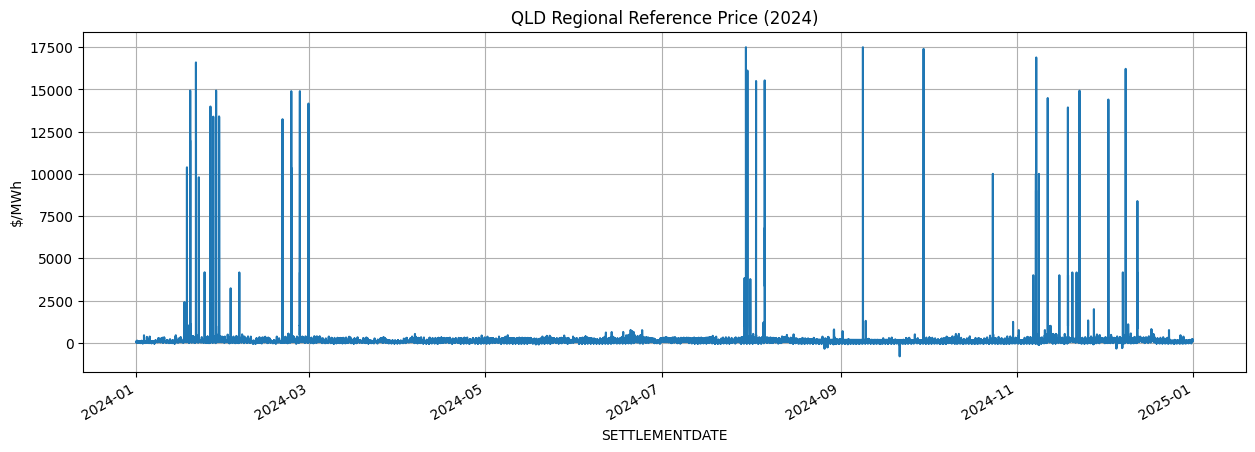

In [14]:
df_price_cleaned.set_index("SETTLEMENTDATE")["RRP"].plot(figsize=(15, 5), title="QLD Regional Reference Price (2024)")
plt.ylabel("$/MWh")
plt.grid()
plt.show()


In [15]:
df_price_cleaned = pd.DataFrame(dispatchprice_data)


# Detect Price Anomalies 


## Method A: Statistical Thresholds
Flag prices that are:

Too high: above the 99th percentile or > $1,000


Too low: below -$100 (NEM sometimes goes negative)

In [16]:
# Set thresholds (you can adjust)
high_threshold = 1000  # e.g., extreme high price
low_threshold = -100   # e.g., negative pricing outlier

# Add anomaly flag
df_price_cleaned["is_anomaly"] = (
    (df_price_cleaned["RRP"] > high_threshold) |
    (df_price_cleaned["RRP"] < low_threshold)
)

# Count how many anomalies were detected
df_price_cleaned["is_anomaly"].sum()


np.int64(293)

Plot With Anomalies Highlighted


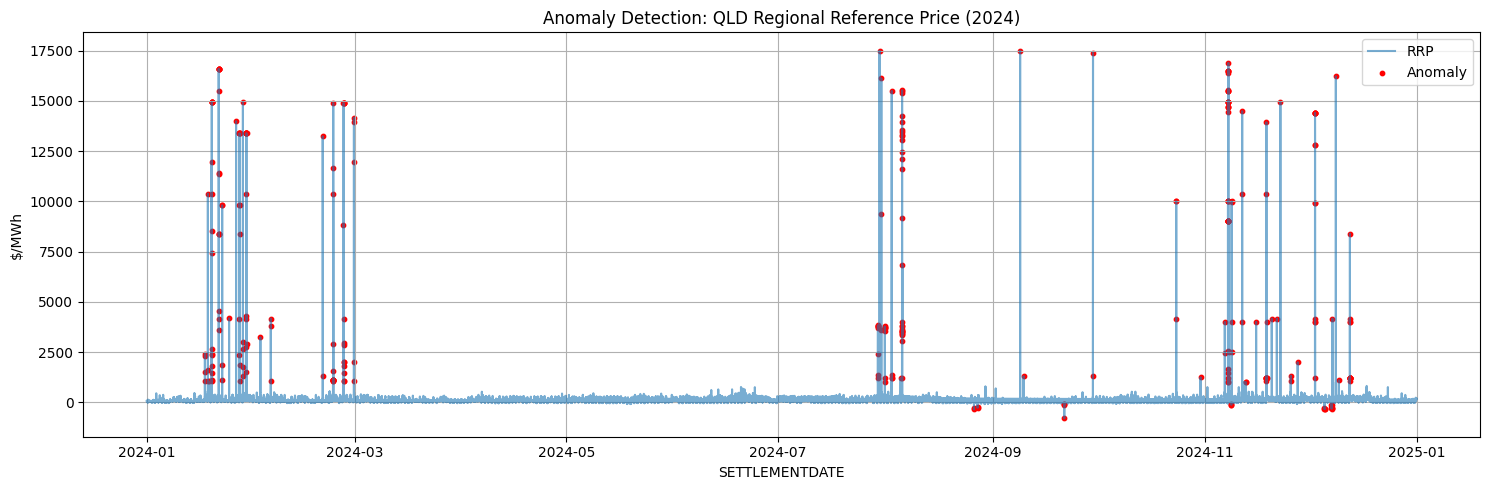

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_price_cleaned["SETTLEMENTDATE"], df_price_cleaned["RRP"], label="RRP", alpha=0.6)

# Plot anomalies
anomalies = df_price_cleaned[df_price_cleaned["is_anomaly"]]
plt.scatter(anomalies["SETTLEMENTDATE"], anomalies["RRP"], color='red', label="Anomaly", s=10)

plt.title("Anomaly Detection: QLD Regional Reference Price (2024)")
plt.xlabel("SETTLEMENTDATE")
plt.ylabel("$/MWh")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


 Merge the Two DataFrames

In [19]:
# If needed, reload your demand data
df_demand = pd.read_csv("QLD_DISPATCHREGIONSUM_2024_CLEANED.csv", parse_dates=["SETTLEMENTDATE"])

# Merge on SETTLEMENTDATE
df_merged = pd.merge(
    df_price_cleaned,
    df_demand,
    on="SETTLEMENTDATE",
    how="inner"
)

# Check the result
df_merged.head()


,SETTLEMENTDATE,REGIONID_x,INTERVENTION,RRP,ROP,PRICE_STATUS,is_anomaly,rolling_mean,rolling_std,z_score,z_anomaly,REGIONID_y,TOTALDEMAND,AVAILABLEGENERATION,INTERCONNECTORFLOWS
0,2024-04-01 00:05:00,QLD1,1,59.66236,59.66236,0.01,False,NaN,NaN,NaN,False,QLD1,5857.74,9382.40581,-134.93
1,2024-04-01 00:10:00,QLD1,1,59.75000,59.75000,1.12,False,NaN,NaN,NaN,False,QLD1,5870.65,9375.95286,-143.16
2,2024-04-01 00:15:00,QLD1,1,59.20843,59.20843,0,False,NaN,NaN,NaN,False,QLD1,5749.58,9359.09189,-80.48
3,2024-04-01 00:20:00,QLD1,1,59.59650,59.59650,3.71,False,NaN,NaN,NaN,False,QLD1,5836.45,9355.92854,-141.32
4,2024-04-01 00:25:00,QLD1,1,58.49123,58.49123,1.2,False,NaN,NaN,NaN,False,QLD1,5802.74,9356.95295,-135.93


Compare Anomalies vs Normal Conditions

In [20]:
# Split data
anomalies = df_merged[df_merged["is_anomaly"] == True]
normal = df_merged[df_merged["is_anomaly"] == False]

# Compare means
print("🔺 Anomaly Periods")
print("Avg TOTALDEMAND:", anomalies["TOTALDEMAND"].mean())
print("Avg AVAILABLEGENERATION:", anomalies["AVAILABLEGENERATION"].mean())
print("Avg INTERCONNECTORFLOWS:", anomalies["INTERCONNECTORFLOWS"].mean())

print("\n🔹 Normal Periods")
print("Avg TOTALDEMAND:", normal["TOTALDEMAND"].mean())
print("Avg AVAILABLEGENERATION:", normal["AVAILABLEGENERATION"].mean())
print("Avg INTERCONNECTORFLOWS:", normal["INTERCONNECTORFLOWS"].mean())


🔺 Anomaly Periods
Avg TOTALDEMAND: 8694.335563139934
Avg AVAILABLEGENERATION: 10170.190643515358
Avg INTERCONNECTORFLOWS: 391.1482935153584

🔹 Normal Periods
Avg TOTALDEMAND: 6214.2579833762875
Avg AVAILABLEGENERATION: 9760.319610368899
Avg INTERCONNECTORFLOWS: 202.57231885574072


Visualise Price vs Demand (Highlight Anomalies)

In [25]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


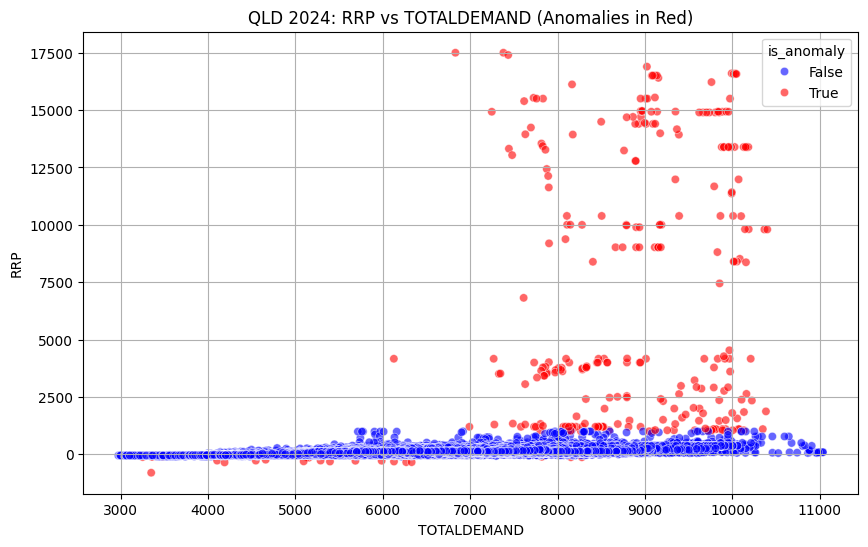

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_merged,
    x="TOTALDEMAND", y="RRP",
    hue="is_anomaly",
    palette={True: "red", False: "blue"},
    alpha=0.6
)
plt.title("QLD 2024: RRP vs TOTALDEMAND (Anomalies in Red)")
plt.grid()
plt.show()
